In [1]:
!nvidia-smi --query-gpu=name,driver_version,memory.total --format=csv
!wmic cpu get name, numberofcores, maxclockspeed

name, driver_version, memory.total [MiB]
NVIDIA GeForce RTX 4060 Ti, 560.94, 8188 MiB
MaxClockSpeed  Name                                NumberOfCores  

3701           AMD Ryzen 5 5600X 6-Core Processor  6              





In [2]:
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import time
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def generate_matrix(matrix_size: int):
    """
    Генерирует случайную матрицу заданного размера.

    Args:
        matrix_size: Размер матрицы (N x N)

    Returns:
        np.ndarray: Сгенерированная матрица
    """
    return np.random.rand(matrix_size, matrix_size).astype(np.float32)


def validate_results(solution, C):
    """
    Проверяет корректность результатов умножения матриц.
    
    Args:
        solution: Эталонное решение
        C: Проверяемый результат
        
    Returns:
        bool: True если результаты совпадают с заданной точностью
    """
    return np.allclose(solution, C, atol=1e-6)


def timer_decorator(func):
    """
    Декоратор для измерения времени выполнения функции.
    
    Returns:
        tuple: (результат функции, время выполнения в секундах)
    """
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        return result, end_time - start_time

    return wrapper

In [4]:
@timer_decorator
def cpu_mat_mul(A: np.ndarray, B: np.ndarray):
    """
    Умножение матриц на CPU.

    Args:
        A: Первая матрица
        B: Вторая матрица

    Returns:
        np.ndarray: Результат умножения матриц
    """
    C = np.zeros((A.shape[0], B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                C[i, j] += A[i, k] * B[k, j]
    return C

In [10]:
with open("kernel.cu", "r") as f:
    kernel = f.read()


@timer_decorator
def gpu_mat_mul(A, B):
    """
    Умножение матриц на GPU.

    Args:
        A: Первая матрица
        B: Вторая матрица

    Returns:
        np.ndarray: Результат умножения матриц
    """
    C = np.zeros((A.shape[0], B.shape[1]), dtype=np.float32)

    # Выделение памяти на GPU
    A_gpu = cuda.mem_alloc(A.nbytes)
    B_gpu = cuda.mem_alloc(B.nbytes)
    C_gpu = cuda.mem_alloc(C.nbytes)

    # Копирование данных на GPU
    cuda.memcpy_htod(A_gpu, A)
    cuda.memcpy_htod(B_gpu, B)

    # Компиляция и загрузка CUDA-кода
    mod = SourceModule(kernel)
    matrix_mul = mod.get_function("matrixMulKernel")

    # Определяем размеры блока и сетки для распараллеливания
    block_size = (16, 16, 1)
    grid_size = (
        (B.shape[1] + block_size[0] - 1) // block_size[0],
        (A.shape[0] + block_size[1] - 1) // block_size[1],
    )

    # Запуск ядра на GPU
    matrix_mul(
        A_gpu,
        B_gpu,
        C_gpu,
        np.int32(A.shape[0]),
        np.int32(A.shape[1]),
        np.int32(B.shape[1]),
        block=block_size,
        grid=grid_size,
    )

    cuda.Context.synchronize()

    # Копирование результата с GPU на CPU
    cuda.memcpy_dtoh(C, C_gpu)

    return C

In [11]:
matrix_sizes = [100, 500, 1000, 1500, 2000]

In [ ]:
array = []

for matrix_size in tqdm(matrix_sizes):
    A = generate_matrix(matrix_size)
    B = generate_matrix(matrix_size)
    print(f"Размер матриц: {matrix_size}x{matrix_size}")

    C_cpu, time_taken_cpu = cpu_mat_mul(A, B)
    if not validate_results(A @ B, C_cpu):
        print("CPU | Результаты не корректны")

    C_gpu, time_taken_gpu = gpu_mat_mul(A, B)

    if not validate_results(A @ B, C_gpu):
        print("GPU | Результаты не корректны")

    array.append(
        [
            f"{matrix_size}x{matrix_size}",
            time_taken_cpu,
            time_taken_gpu,
            time_taken_cpu / time_taken_gpu,
        ]
    )

df = pd.DataFrame(
    array, columns=["Размер матриц", "Время CPU", "Время GPU", "Ускорение"]
)
df

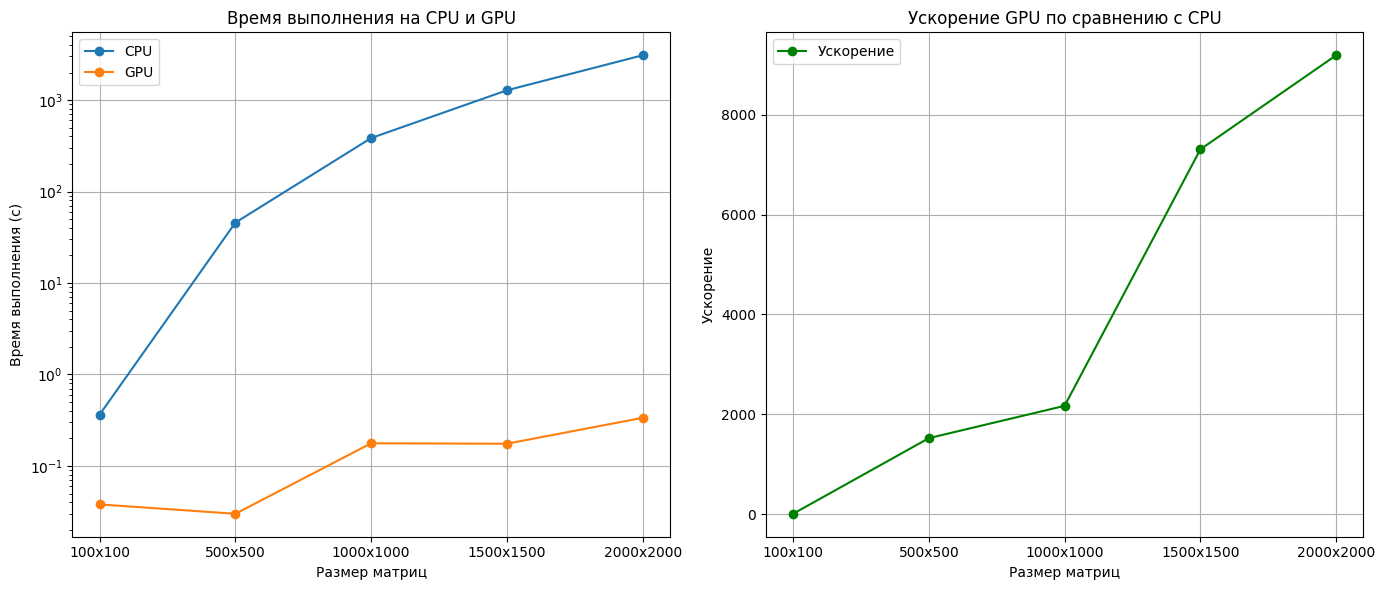

In [9]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(df["Размер матриц"], df["Время CPU"], label="CPU", marker="o")
plt.plot(df["Размер матриц"], df["Время GPU"], label="GPU", marker="o")
plt.xlabel("Размер матриц")
plt.ylabel("Время выполнения (с)")
plt.title("Время выполнения на CPU и GPU")
plt.yscale("log")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(
    df["Размер матриц"], df["Ускорение"], label="Ускорение", marker="o", color="green"
)
plt.xlabel("Размер матриц")
plt.ylabel("Ускорение")
plt.title("Ускорение GPU по сравнению с CPU")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()